In [5]:
total_iku = 102.2

pol_co = 244.5
pol_co2 = 59.7
pol_so2 = 35.9
pol_no2 = 107.5

total_pol = pol_co + pol_co2 + pol_so2 + pol_no2

# kontribusi emisi kendaraan terhadap AQI
kontribusi_co = pol_co/total_pol * total_aqi * 0.919  
kontribusi_co2 = pol_co2/total_pol * total_aqi * 0.847  
kontribusi_so2 = pol_so2/total_pol * total_aqi * 0.758  
kontribusi_no2 = pol_no2/total_pol * total_aqi * 0.707  

total_kontribusi = kontribusi_co + kontribusi_co2 + kontribusi_so2 + kontribusi_no2

persentase_kontribusi = (total_kontribusi / total_iku) * 100

# Hasil
print(f"Total Kontribusi Kendaraan terhadap AQI: {total_kontribusi}")
print(f"Persentase Kontribusi Kendaraan: {persentase_kontribusi:.2f}%")


Total Kontribusi Kendaraan terhadap AQI: 86.41701836461128
Persentase Kontribusi Kendaraan: 84.56%


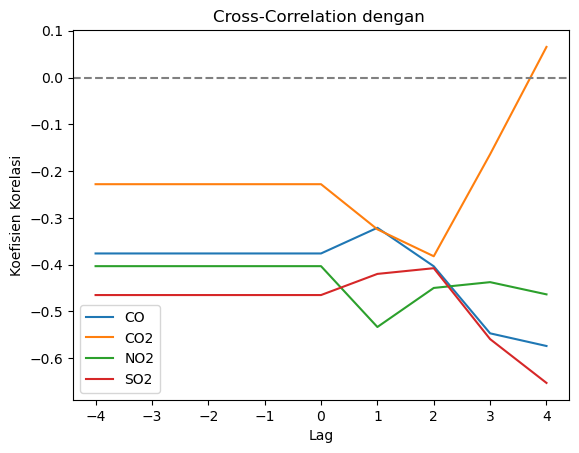

In [7]:
#Uji Korelasi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate

#
data = {
    'CO': [424.4, 550.2, 281.8, 300, 380.5, 194.7, 237.9, 185.4, 197.5, 172.7, 164.2, 170.7, 251.5, 224.4, 155.3, 21.3],
    'CO2': [24.7, 61.2, 63.7, 63.7, 72, 72.8, 66, 62.7, 64.5, 62.8, 61.8, 60.6, 41.4, 30, 74, 73.4],
    'NO2': [57.6, 149, 159.1, 158.4, 151.3, 112.9, 107.4, 99.8, 101.3, 95.3, 95.6, 92.8, 98.2, 65.4, 47.6, 128.2],
    'SO2': [39.5, 55.3, 51, 51.4, 47.8, 32.7, 33.2, 31.3, 30.5, 29.7, 30.9, 31.3, 33.7, 35.2, 20.1, 20.1],
    'AQI': [84, 88, 83, 83, 79, 92, 80, 77, 77, 70, 94, 109, 159, 156, 153, 151]
}
df = pd.DataFrame(data)

# Cross-Corellation
def compute_cross_correlation(pollutant, aqi, lags):
    cross_corr = [np.corrcoef(pollutant[:-lag] if lag > 0 else pollutant, aqi[lag:] if lag > 0 else aqi)[0, 1] 
                  for lag in lags]
    return cross_corr

lags = range(-4, 5)

for pollutant in ['CO', 'CO2', 'NO2', 'SO2']:
    cross_corr = compute_cross_correlation(df[pollutant], df['AQI'], lags)
    plt.plot(lags, cross_corr, label=pollutant)

# Visualisasi
plt.axhline(0, color='gray', linestyle='--')
plt.title("Cross-Correlation dengan ")
plt.xlabel("Lag")
plt.ylabel("Koefisien Korelasi")
plt.legend()
plt.show()

In [16]:
import numpy as np
from scipy.spatial.distance import cdist


wilayah_data = {
    "Kulon Progo": {"populasi": 464602, "koordinat": (-7.8663, 110.1543)},
    "Bantul": {"populasi": 1106992, "koordinat": (-7.9027, 110.3556)},
    "Gunung Kidul": {"populasi": 804842, "koordinat": (-8.0306, 110.6168)},
    "Sleman": {"populasi": 1335947, "koordinat": (-7.7170, 110.3556)},
    "Kota Yogyakarta": {"populasi": 466950, "koordinat": (-7.8014, 110.3646)},
}

def evaluate_fitness(spklu_coords, wilayah_coords, wilayah_populasi):
    distances = cdist(spklu_coords, wilayah_coords, metric="euclidean")
    weighted_distances = (distances * wilayah_populasi).sum(axis=1)
    return -weighted_distances.sum()


num_spklu = 10
num_generations = 100
population_size = 50
mutation_rate = 0.2
latitude_bounds = (-8.2, -7.5)
longitude_bounds = (110.1, 110.6)


def initialize_population(size, num_points):
    return np.random.uniform(
        [latitude_bounds[0], longitude_bounds[0]],
        [latitude_bounds[1], longitude_bounds[1]],
        size=(size, num_points, 2),
    )


def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, num_spklu - 1)
    child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2


def mutate(individual, rate):
    for i in range(len(individual)):
        if np.random.rand() < rate:
            individual[i] = np.random.uniform(
                [latitude_bounds[0], longitude_bounds[0]],
                [latitude_bounds[1], longitude_bounds[1]],
            )
    return individual


wilayah_coords = np.array([wilayah_data[k]["koordinat"] for k in wilayah_data])
wilayah_populasi = np.array([wilayah_data[k]["populasi"] for k in wilayah_data])
population = initialize_population(population_size, num_spklu)
best_solution = None
best_fitness = float("-inf")

for generation in range(num_generations):
    fitness = np.array([
        evaluate_fitness(individual, wilayah_coords, wilayah_populasi)
        for individual in population
    ])
    selected_indices = np.argsort(fitness)[-population_size // 2:]
    selected_population = population[selected_indices]
    new_population = []
    for i in range(0, len(selected_population), 2):
        if i+1 < len(selected_population):
            child1, child2 = crossover(
                selected_population[i], selected_population[i+1]
            )
            new_population.extend([child1, child2])
    new_population = np.array(new_population)
    for individual in new_population:
        mutate(individual, mutation_rate)
    population = np.vstack((selected_population, new_population[:population_size//2]))
    current_best = population[np.argmax(fitness)]
    current_best_fitness = fitness.max()
    if current_best_fitness > best_fitness:
        best_fitness = current_best_fitness
        best_solution = current_best


print("Koordinat SPKLU Optimal:", best_solution)
print("Fitness Terbaik:", -best_fitness)

Koordinat SPKLU Optimal: [[ -7.79423566 110.39292878]
 [ -7.86115759 110.35779448]
 [ -7.80803309 110.34577359]
 [ -7.87192892 110.38898834]
 [ -7.90962391 110.57762129]
 [ -7.53806794 110.47042685]
 [ -7.74800458 110.40070044]
 [ -7.8500069  110.32347958]
 [ -7.86250546 110.42610323]
 [ -7.87584663 110.39298108]]
Fitness Terbaik: 6395905.53469298


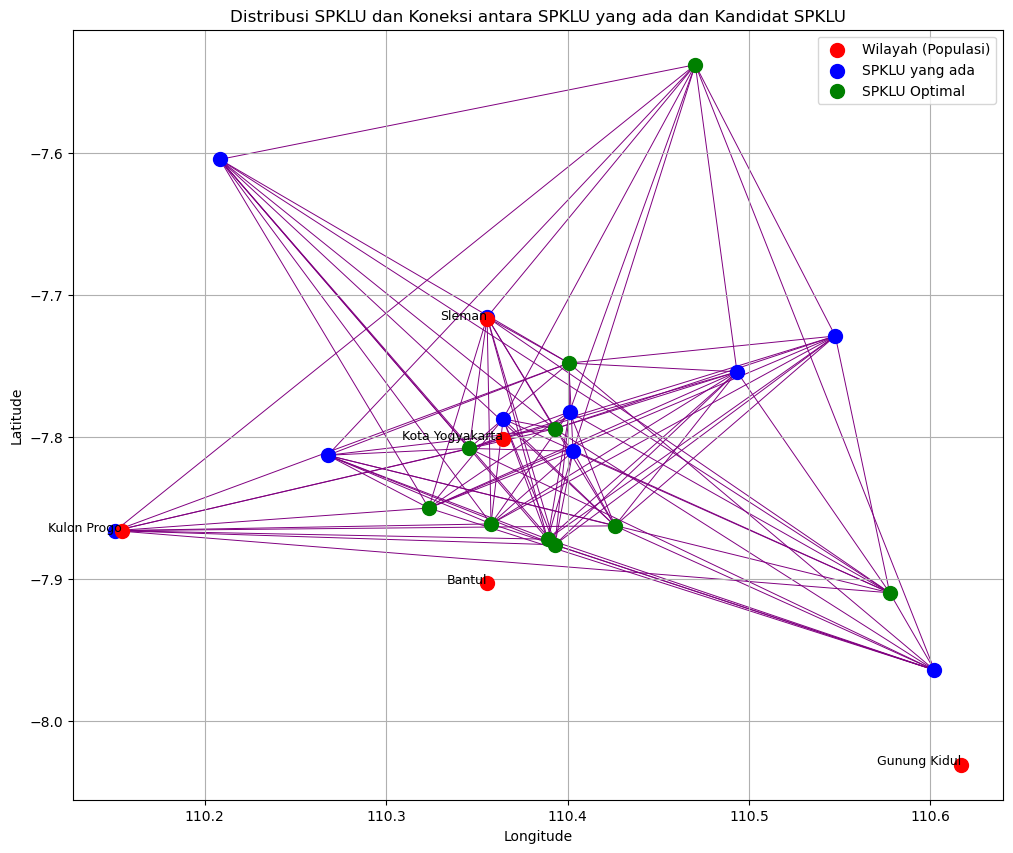

In [20]:
import matplotlib.pyplot as plt

spklu_existing = np.array([
    [-7.7872684872248055, 110.36447672024],   # RISS Hotel Malioboro
    [-7.810090533591732, 110.40300414907556], # PLN UP3 Yogyakarta
    [-7.782364144731137, 110.40106827785411], # Hotel Royal Ambarrukmo
    [-7.715687608649719, 110.35562957791113], # PLN UP Sleman
    [-7.812862095897391, 110.2677258779111],  # PLN UP Sedayu
    [-7.728942976548787, 110.54762744907555], # PLN UP Kalasan
    [-7.865921223528121, 110.15062764907555], # PLN UP Wates
    [-7.963984381596708, 110.6022911779111],  # PLN UP Wonosari
    [-7.604701096773972, 110.20827387791113], # Taman Wisata Candi Borobudur
    [-7.75415453149233, 110.49341680674667],  # Kawasan Candi Prambanan
])

wilayah_labels = list(wilayah_data.keys())
wilayah_coords = np.array([wilayah_data[k]["koordinat"] for k in wilayah_data])

kandidat_spklu = best_solution

def plot_locations(spklu_existing, wilayah_coords, kandidat_spklu, wilayah_labels):
    plt.figure(figsize=(12, 10))

    plt.scatter(
        wilayah_coords[:, 1], wilayah_coords[:, 0],
        color='red', label='Wilayah (Populasi)', s=100, zorder=3
    )
    for i, label in enumerate(wilayah_labels):
        plt.text(
            wilayah_coords[i, 1], wilayah_coords[i, 0],
            label, fontsize=9, ha='right'
        )

    plt.scatter(
        spklu_existing[:, 1], spklu_existing[:, 0],
        color='blue', label='SPKLU yang ada', s=100, zorder=2
    )

    plt.scatter(
        kandidat_spklu[:, 1], kandidat_spklu[:, 0],
        color='green', label='SPKLU Optimal', s=100, zorder=4
    )

    for spklu in spklu_existing:
        for kandidat in kandidat_spklu:
            plt.plot(
                [spklu[1], kandidat[1]], [spklu[0], kandidat[0]],
                color='purple', linestyle='-', linewidth=0.7, zorder=1
            )


    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Distribusi SPKLU dan Koneksi antara SPKLU yang ada dan Kandidat SPKLU')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_locations(spklu_existing, wilayah_coords, kandidat_spklu, wilayah_labels)